# Boosting ground states preparation interfacing VQEs and DBQAs

In [71]:
import copy

import numpy as np
import matplotlib.pyplot as plt

import cma

import qibo
from qibo import hamiltonians, optimizers, gates, Circuit

from qibo.models.dbi.double_bracket import (
    DoubleBracketIteration,
    DoubleBracketGeneratorType,
)

from boostvqe import ansatze
from boostvqe.utils import rotate_h_with_vqe
from boostvqe.models.dbi.double_bracket_evolution_oracles import (
    XXZ_EvolutionOracle,
    FrameShiftedEvolutionOracle,
    IsingNNEvolutionOracle
)

from boostvqe.models.dbi.group_commutator_iteration_transpiler import (
    DoubleBracketRotationType,
    GroupCommutatorIterationWithEvolutionOracles,
)

In [72]:
from importlib import reload
reload(ansatze)

<module 'boostvqe.ansatze' from '/home/matteo/Documents/PhD/boostvqe/src/boostvqe/ansatze.py'>

In [73]:
qibo.set_backend("qiboml", platform="tensorflow")
plt.set_loglevel('WARNING') 

[Qibo 0.2.14|INFO|2024-12-04 16:43:25]: Using qiboml (tensorflow) backend on /device:CPU:0
INFO:qibo.config:Using qiboml (tensorflow) backend on /device:CPU:0


#### Some plotting functions

In [74]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    # print the abs value of the components of the matrix
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_vqe_states(state, state2=None):
    """
    Plot `state` and `state2` if provided. 
    """
    n = int(np.log2(len(state)))
    bitstrings = [format(i, f"0{n}b") for i in range(2**n)] 
    
    plt.figure(figsize=(12,4))
    for i, amp in enumerate(state):
        if i == 0:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black", label="Ground state")
        else:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black")
    if state2 is not None:     
        for i, amp in enumerate(state2):
            if i == 0:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none", label="VQE approximation")
            else:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none")
                
    plt.xticks(ticks=range(len(bitstrings)), labels=bitstrings, rotation=90)
    plt.xlabel("Components")
    plt.ylabel("Probabilities")
    plt.title("State representation")
    plt.legend()
    plt.show()

def plot_loss(loss_history, vqe):
    target_gs_energy = np.min(np.array(np.real(vqe.hamiltonian.eigenvalues())))
    plt.figure(figsize=(6, 6 * 6 / 8))
    plt.plot(loss_history, color="purple", label="Loss history", lw=1.5, alpha=0.7)
    plt.hlines(target_gs_energy, 0, len(loss_history), color="black", label="Target GS energy", lw=1.5, alpha=0.7, ls="--")
    plt.legend()
    plt.show()

#### Problem setup

We consider an Hamming-weight preserving ansatz to approximate the target circuit. It is a good choice to reduce the complexity of the circuit while perfectly fulfilling the problem simmetries.

In [75]:
# Fix the size of the problem
nqubits = 6
nlayers = 3

In [76]:
# Build circuit
# circ0 = ansatze.hdw_efficient(nqubits=nqubits, nlayers=nlayers)
circ0 = ansatze.hw_preserving(nqubits=nqubits, nlayers=nlayers)
circ0.draw()

# We save a copy of the circuit for later
circ = circ0.copy(deep=True)

0:     ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS─────────────────RBS ...
1:     ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS─────────RBS─────|── ...
2:     ─X─────RBS─────RBS─────|───RBS─────|───|───────────RBS─────RBS─────|── ...
3:     ───────RBS─────────RBS─|───────RBS─RBS─|───RBS─────RBS─────────RBS─|── ...
4:     ───────────RBS─────RBS─|───────|───────RBS─|───────────RBS─────RBS─|── ...
5:     ───────────RBS─────────RBS─────RBS─────────RBS─────────RBS─────────RBS ...

0: ... ─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────
1: ... ─|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────
2: ... ─RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|───────
3: ... ─────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS─
4: ... ─────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|───
5: ... ─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS─


In [77]:
# Initial parameters are zeros
default_params = circ.get_parameters()
nparams = len(default_params)
print(f" Default params: {default_params}\n nparams: {nparams}")

 Default params: [(0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,)]
 nparams: 33


In [78]:
# Build input Hamiltonian
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
ground_state = h0.ground_state()
gs_energy = np.min(np.real(h0.eigenvalues()))

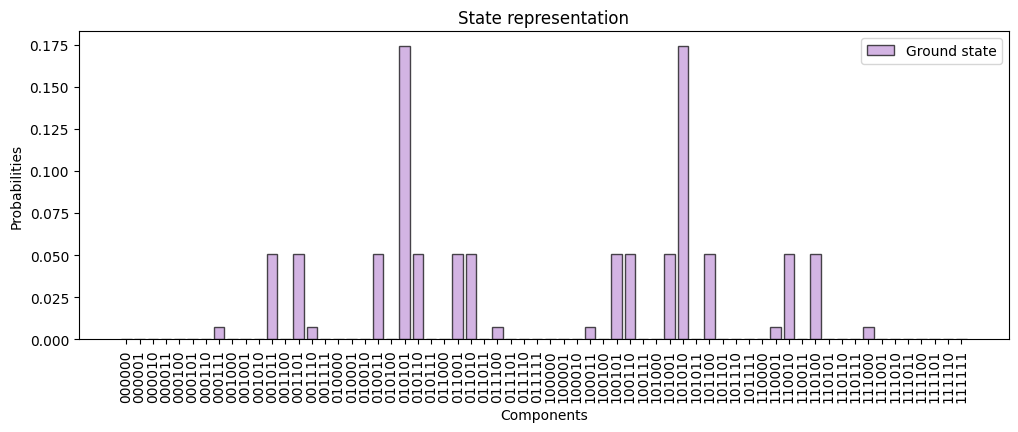

In [79]:
# Plot one (or eventually two) states
plot_vqe_states(ground_state)

In [80]:
# Initialize VQE object
vqe = ansatze.VQE(circuit=circ, hamiltonian=copy.deepcopy(h0))

#### Train the VQE

We now use the Qibo Tensorflow backend to train the VQE with a gradient descent strategy.

In [81]:
# Set initial params
initial_parameters  = np.random.normal(0., 0.5, nparams)

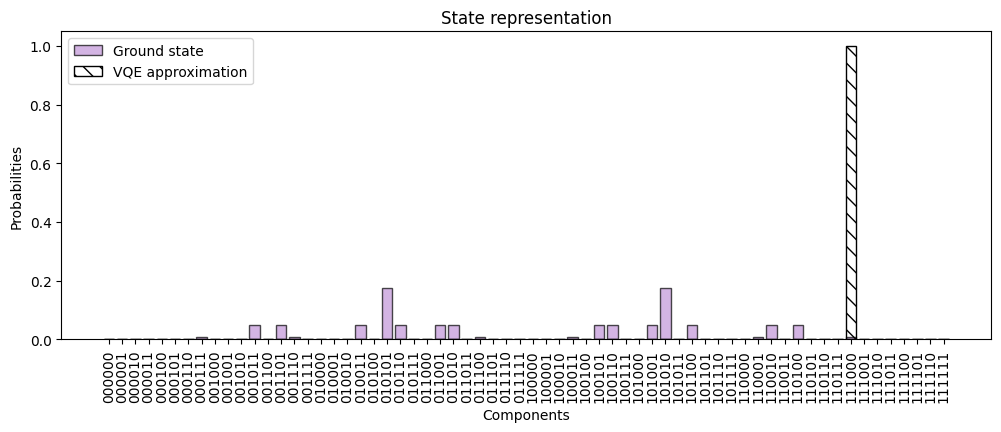

In [82]:
# VQE ground state before setting initial parameters
plot_vqe_states(ground_state, vqe.circuit().state())

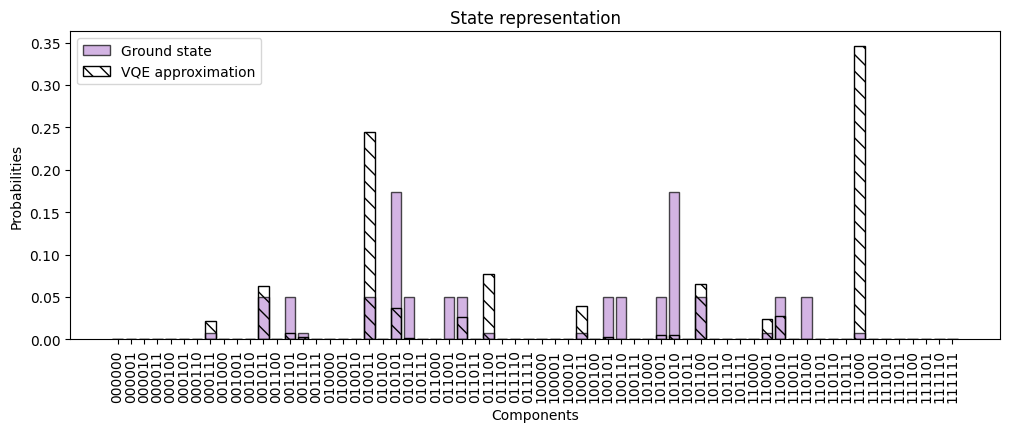

In [83]:
# Set random parameters and re-plot the states
vqe.circuit.set_parameters(initial_parameters)
plot_vqe_states(ground_state, vqe.circuit().state())

##### Defining some callbacks to keep track during optimization

In [87]:
loss_history, params_history = [], []

def tracker_function(
    params, 
    vqe=vqe, 
    loss_history=loss_history,
    params_history=params_history,
):
    """Keep track of loss function and VQE params history during the optimization."""
    vqe.circuit.set_parameters(params)
    loss_history.append(
        vqe.hamiltonian.expectation(
            vqe.circuit().state()
        )
    )
    params_history.append(params)
    print(f"Exec. iteration {len(loss_history)} \t Loss: {loss_history[-1]}")

In [88]:
# Optimization options
optimizer_options = {
    "nepochs" : 80,
    "method": "Adam",
    "nmessage": 1,
    "learning_rate": 0.05,
}

# Fix the random seed
backend = qibo.get_backend().tf.random.set_seed(42)

# Use the vqe.minimize method
opt_results = vqe.minimize(
    initial_parameters, 
    method="sgd", 
    options=optimizer_options,
    callback=tracker_function
)

Exec. iteration 1 	 Loss: -0.9996166763365224
Exec. iteration 2 	 Loss: -1.7611636791838854
Exec. iteration 3 	 Loss: -2.4932696456630943
Exec. iteration 4 	 Loss: -3.167311466061833
Exec. iteration 5 	 Loss: -3.738113820408618
Exec. iteration 6 	 Loss: -4.16496844595919
Exec. iteration 7 	 Loss: -4.478488256596702
Exec. iteration 8 	 Loss: -4.75155424906442
Exec. iteration 9 	 Loss: -5.035315325015876
Exec. iteration 10 	 Loss: -5.34434467853892
Exec. iteration 11 	 Loss: -5.673615764330243
Exec. iteration 12 	 Loss: -6.0130848141269055
Exec. iteration 13 	 Loss: -6.352884301029148
Exec. iteration 14 	 Loss: -6.683884089593695
Exec. iteration 15 	 Loss: -6.997762166016317
Exec. iteration 16 	 Loss: -7.287674496292503
Exec. iteration 17 	 Loss: -7.548975295892179
Exec. iteration 18 	 Loss: -7.779494459151346
Exec. iteration 19 	 Loss: -7.979308413911848
Exec. iteration 20 	 Loss: -8.150191506368909
Exec. iteration 21 	 Loss: -8.294978899817977
Exec. iteration 22 	 Loss: -8.417003844603

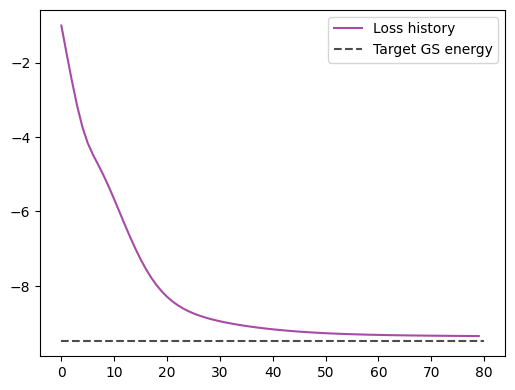

In [89]:
plot_loss(loss_history, vqe)

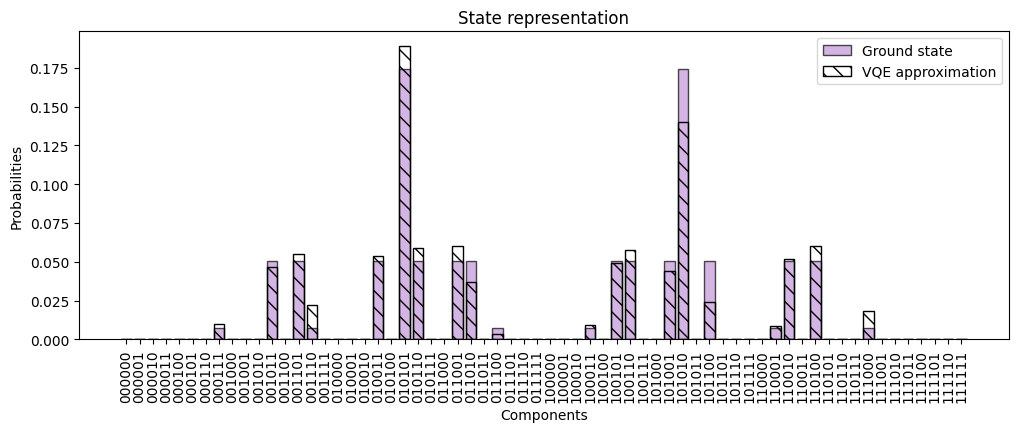

In [90]:
# Plot the VQE approximation together with the target
plot_vqe_states(ground_state, vqe.circuit().state())

#### Apply DBQA after warm start

As explained in the talk, we aim to apply a DBI to a target input of shape:
$$ \hat{A}_0 = \hat{U}^{\dagger} \hat{H}_0 \hat{U}.$$
The procedure is then analogous to the one implemented in the notebook of the last week. 
We will start by applying a DBI, while in a second moment we will move to a GCI (transpiled and compiled DBI).

In [91]:
# We interface the VQE with the DBQA by setting A  = (U^dagger H U)
vqe_unitary = np.matrix(vqe.circuit.unitary())
rotated_h_matrix = vqe_unitary.getH() @ h0.matrix @ vqe_unitary

In [92]:
# Transform it into a Qibo hamiltonian
rotated_h = hamiltonians.Hamiltonian(nqubits=nqubits, matrix=rotated_h_matrix)

Now we can use this new input to build a DBI.

In [93]:
# Construct the DBI
dbi = DoubleBracketIteration(
    hamiltonian=rotated_h,
    mode=DoubleBracketGeneratorType.single_commutator,
)

In [94]:
# Apply three steps of DBI
operators, energies = [], []
for _ in range(3):
    dbi_op = dbi(step=0.01, d=dbi.diagonal_h_matrix)
    zero_state = np.transpose([dbi.h.backend.zero_state(dbi.h.nqubits)])
    energies.append(dbi.h.expectation(zero_state))
    # Collect DBI operators
    operators.append(dbi_op)

In [95]:
# Collect DBI operators
dbi_operators = [
    h0.backend.cast(np.matrix(h0.backend.to_numpy(operator)))
    for operator in operators
]

In [96]:
# Print energies after each DBI step
energies

[<tf.Tensor: shape=(), dtype=float64, numpy=-9.454382138002325>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.46630013883287>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.469553788419985>]

In [97]:
# Constructing a circuit containing initial VQE and DBI operators 
old_circ_matrix = circ.unitary()

circ = Circuit(nqubits)
for gate in reversed([old_circ_matrix] + operators):
    circ.add(gates.Unitary(gate, *range(nqubits), trainable=False))

In [98]:
circ.draw()

0: ─U─U─U─U─
1: ─U─U─U─U─
2: ─U─U─U─U─
3: ─U─U─U─U─
4: ─U─U─U─U─
5: ─U─U─U─U─


In [99]:
# Construct a VQE out of this circuit
vqe1 = ansatze.VQE(hamiltonian=copy.deepcopy(h0), circuit=circ)

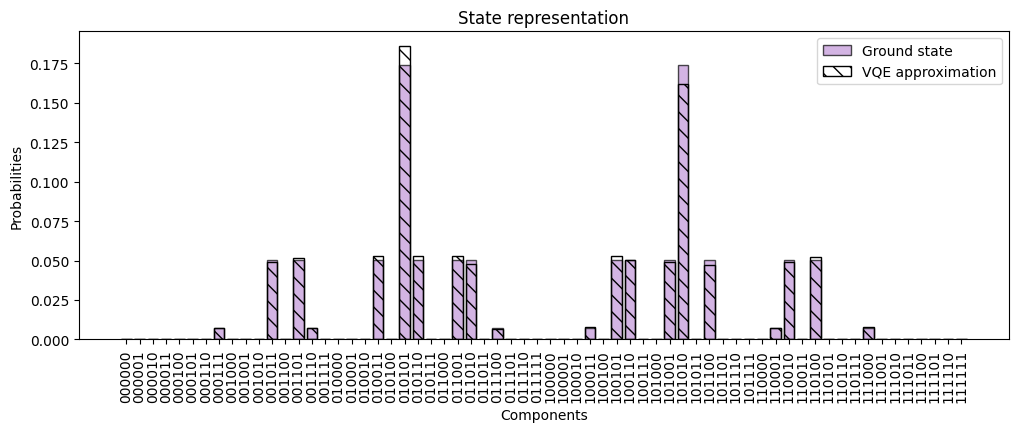

In [100]:
# Plotting Boosted VQE state
plot_vqe_states(ground_state, vqe1.circuit().state())

#### Apply GCI (you are allowed to disconnect here XD)

Now I will show you how to do the same but using a GCI, namely a synthetized and compiled version of the DBI.
I will not delve deep inside the compilation itelf but show you the tools that can be extracted from `boostvqe` to explore it.

In [101]:
qibo.set_backend("numpy")

[Qibo 0.2.14|INFO|2024-12-04 16:44:33]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In [102]:
def loss_function_gci(
    params, 
    gci,
    ham,
    dbr_mode,
):
    """Execute a copy of GCI and compute expval."""
    gci_copy = copy.deepcopy(gci)
    # collect parameters

    eo_d_type = IsingNNEvolutionOracle
    eo_d = eo_d_type.load(params[1:])
    
    gci_copy(step_duration=params[0], diagonal_association=eo_d, mode_dbr=dbr_mode)
    gci_circuit = gci_copy.get_composed_circuit()

    return ham.expectation(gci_circuit().state())

def optimize_GCI(
    gci, 
    params, 
    ham,
    dbr_mode,
    s_bounds=(1e-4, 1.), 
    b_bounds=(0., 9.),
):
    """
    Optimize all hyper-parameters of the GCI, namely the stepsize and the alphas and betas
    which parametrize the D operator.
    """

    lower_bounds = s_bounds[0] + b_bounds[0] * (len(params) - 1)
    upper_bounds = s_bounds[1] + b_bounds[1] * (len(params) - 1)
    bounds = [lower_bounds, upper_bounds]
    result = cma.fmin(
        loss_function_gci,
        sigma0=0.5,
        x0=params,
        args=(gci, ham, dbr_mode),
        options={"bounds": bounds, "maxiter": 100},
    )[0]
    return result

In [122]:
# XXZ hamiltonian oracle
# steps stand for time steps, while order is the Trotter-Suzuki order
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=3, order=2
)

# This is implementing the frame shifting evolution oracle strategy 
# introduced by Marek in (https://arxiv.org/abs/2206.11772)
oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
    before_circuit=vqe.circuit.invert(),
    after_circuit=vqe.circuit,
    base_evolution_oracle=base_oracle,
)

# This is the synthetis strategy: third order group commutator formula with reduction
# namely dropping the first term not impacting in the cost function evaluation
dbr_type = DoubleBracketRotationType.group_commutator_third_order_reduced

# Here we are: the GCI
gci = GroupCommutatorIterationWithEvolutionOracles(
    input_hamiltonian_evolution_oracle=oracle,
    double_bracket_rotation_type=dbr_type,
)

In [129]:
# Collect and show the initial GCI circuit
gci_circuit = gci.get_composed_circuit()

print(f"GCI initial circuit:\n")
gci_circuit.draw()

print(f"\n\nGCI initial circui summary:\n")
print(gci_circuit.summary())

GCI initial circuit:

0:     ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS─────────────────RBS ...
1:     ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS─────────RBS─────|── ...
2:     ─X─────RBS─────RBS─────|───RBS─────|───|───────────RBS─────RBS─────|── ...
3:     ───────RBS─────────RBS─|───────RBS─RBS─|───RBS─────RBS─────────RBS─|── ...
4:     ───────────RBS─────RBS─|───────|───────RBS─|───────────RBS─────RBS─|── ...
5:     ───────────RBS─────────RBS─────RBS─────────RBS─────────RBS─────────RBS ...

0: ... ─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────
1: ... ─|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────
2: ... ─RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|───────
3: ... ─────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS─
4: ... ─────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|───
5: ... ─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS─


GCI initial circui summary:

Circuit depth = 

In [130]:
# Defining the parametrization of the D operator
eo_d_type = IsingNNEvolutionOracle

# Initial parameters for the parametrization
params = [0.01]
params.extend(np.random.uniform(0., 6., nqubits * 2))

# This command can be used to load the parameters
eo_d = eo_d_type.load(params[1:])

In [131]:
# Reconstructing the Hamiltonian in the new (numpy) backend 
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

In [114]:
# Optimizing the GCI
opt_results = optimize_GCI(
    gci=gci,
    params=params,
    ham=h0,
    dbr_mode=dbr_type,
)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 13 (seed=423086, Wed Dec  4 16:46:22 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 -9.349549664034239e+00 1.0e+00 4.84e-01  5e-01  5e-01 0:03.7
    2     22 -9.258005313271493e+00 1.1e+00 4.45e-01  4e-01  5e-01 0:07.4
    3     33 -9.346958222525924e+00 1.2e+00 4.09e-01  4e-01  4e-01 0:10.8
    4     44 -9.142604720556655e+00 1.3e+00 4.08e-01  4e-01  4e-01 0:14.5
    6     66 -9.190506690850942e+00 1.4e+00 4.01e-01  3e-01  4e-01 0:21.6
    8     88 -8.340831260775527e+00 1.6e+00 4.19e-01  3e-01  5e-01 0:29.0
   10    110 -9.273586353814673e+00 1.7e+00 4.40e-01  3e-01  5e-01 0:36.1
   12    132 -8.636698705866600e+00 1.9e+00 4.15e-01  3e-01  5e-01 0:43.3
   15    165 -8.993067371658348e+00 2.1e+00 4.27e-01  3e-01  5e-01 0:54.5
   18    198 -9.208555069728726e+00 2.5e+00 4.45e-01  3e-01  5e-01 1:05.4
   21    231 -9.358176253469372e+00 2.8e+00 3.91e-01  2e-01  5e-01 1:16.4
   25    275 -9.324685

In [133]:
# Collect best params
step_duration = opt_results[0]
d_params = opt_results[1:]

In [134]:
# Update the EvolutionOracle with those best params
eo_d = eo_d_type.load(d_params)

In [135]:
# Execute an optimized GCI
gci(step_duration=step_duration, diagonal_association=eo_d, mode_dbr=dbr_type)

In [136]:
# Collect the circuit
gci_circuit = gci.get_composed_circuit()

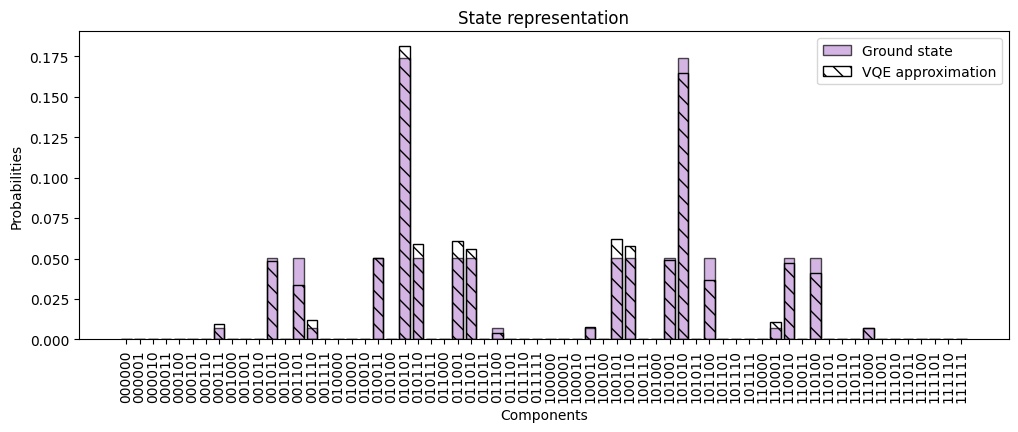

In [138]:
# Plot the GCI state
plot_vqe_states(ground_state, gci_circuit().state())

In [139]:
# Collect and show the new GCI circuit
gci_circuit = gci.get_composed_circuit()

print(f"GCI compiled circuit:\n")
gci_circuit.draw()

print(f"\n\nGCI compiled circui summary:\n")
print(gci_circuit.summary())

GCI compiled circuit:

0:     ─o────o─────────────────────────────X─RZ─X─RZ─o────o────────────────── ...
1:     ─X─RZ─X─o────o──────────────────────|────|─RZ─X─RZ─X─o────o─────────── ...
2:     ────────X─RZ─X─o────o───────────────|────|─RZ────────X─RZ─X─o────o──── ...
3:     ───────────────X─RZ─X─o────o────────|────|─RZ───────────────X─RZ─X─o── ...
4:     ──────────────────────X─RZ─X─o────o─|────|─RZ──────────────────────X─R ...
5:     ─────────────────────────────X─RZ─X─o────o─RZ───────────────────────── ...

0: ... ───────────X─RZ─X─RZ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS ...
1: ... ───────────|────|─RZ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS ...
2: ... ───────────|────|─RZ─X─────RBS─────RBS─────|───RBS─────|───|────────── ...
3: ... ──o────────|────|─RZ───────RBS─────────RBS─|───────RBS─RBS─|───RBS──── ...
4: ... Z─X─o────o─|────|─RZ───────────RBS─────RBS─|───────|───────RBS─|────── ...
5: ... ────X─RZ─X─o────o─RZ───────────RBS─────────RBS─────RBS─────────RBS─